# Results

In this notebook, I will analyze and interpret the information that the model is created.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy.stats import pearsonr

from matplotlib import pyplot,rc
# for mpl animation
import matplotlib.animation as animation
rc('animation', html='html5')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
press_pred = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pressure_predictions.csv")
plays = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pffScoutingData.csv")
players = pd.read_csv("C:/Users/19012/Documents/BDB 2023/players.csv")
games = pd.read_csv("C:/Users/19012/Documents/BDB 2023/games.csv")
tracking = pd.read_csv("C:/Users/19012/Documents/BDB 2023/frame_filter_df.csv")

C:\Users\19012\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
press_pred.shape

(155111, 25)

In [4]:
press_pred.head()

,Unnamed: 0,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,dist_qb,num_rushers,distance_blocker,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress,pressure
0,0,2021090900,41263.0,97,6,0.96,0.90,0.11,3,2,6.0,0,43.30,18.89,7.802083,5.0,3.263817,-1.74,316.48,288.76,1,0,0,0.130755,1
1,1,2021090900,41263.0,97,7,1.08,0.86,0.12,3,2,6.0,0,43.19,18.91,7.766557,5.0,3.172381,-1.74,308.13,282.13,1,0,0,0.140255,1
2,2,2021090900,41263.0,97,8,1.30,0.85,0.16,3,2,6.0,0,43.03,18.93,7.695193,5.0,3.059412,-1.74,310.58,277.08,1,0,0,0.139984,1
3,3,2021090900,41263.0,97,9,1.48,0.79,0.17,3,2,6.0,0,42.87,18.98,7.603138,5.0,2.943739,-1.74,312.75,279.62,1,0,0,0.161547,1
4,4,2021090900,41263.0,97,10,2.16,1.34,0.30,3,2,6.0,0,42.60,19.09,7.404627,5.0,2.695199,-1.74,312.75,286.29,1,0,0,0.111408,1


In [5]:
# average expected pressure per play for each pass rusher
avg_xpress = press_pred.groupby(['gameId','nflId','playId']).mean().reset_index()[['gameId','nflId','playId','xPress','pressure']]
avg_xpress = avg_xpress.rename(columns={'xPress':'avg_xPress', 'pressure':'avg_press'})
avg_xpress.head()

,gameId,nflId,playId,avg_xPress,avg_press
0,2021090900,34777.0,282,0.056998,0.0
1,2021090900,34777.0,788,0.086247,0.0
2,2021090900,34777.0,1078,0.092580,0.0
3,2021090900,34777.0,1918,0.117529,0.0
4,2021090900,34777.0,2656,0.155658,0.0


In [6]:
# take the average per play and calculate the total expected pressure for a player
sum_press = avg_xpress.groupby('nflId').sum().reset_index()[['nflId','avg_xPress','avg_press']]
sum_press = sum_press.rename(columns={'avg_xPress':'total_xPress', 'avg_press':'total_press'})
sum_press.head()

,nflId,total_xPress,total_press
0,34465.0,1.873433,1.0
1,34777.0,1.295632,0.0
2,35441.0,5.757794,3.0
3,35449.0,4.115837,1.0
4,35454.0,4.492294,2.0


In [7]:
plays = plays[plays['pff_role']=='Pass Rush']

In [8]:
snap_count = plays.groupby(by=['nflId']).count().reset_index()[['nflId','playId']]
snap_count = snap_count.rename(columns={'playId': 'snaps'})
snap_count.head()

,nflId,snaps
0,33131,193
1,34465,25
2,34654,4
3,34777,53
4,35441,211


In [9]:
sacks = plays.groupby(by=['nflId']).sum().reset_index()[['nflId','pff_sack']]
sacks.head()

,nflId,pff_sack
0,33131,0.0
1,34465,1.0
2,34654,0.0
3,34777,0.0
4,35441,2.0


In [10]:
sum_press.shape

(387, 3)

In [11]:
final_df = sum_press.merge(players, on=['nflId'])[['nflId','total_xPress', 'total_press','displayName', 'officialPosition']]
# sanity check (678)
print(final_df.shape)
final_df = final_df.merge(snap_count,on=['nflId'])
# sanity check ()
print(final_df.shape)
final_df = final_df.merge(sacks,on=['nflId'])
final_df.head()

(387, 5)
(387, 6)


,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack
0,34465.0,1.873433,1.0,Malcolm Jenkins,SS,25,1.0
1,34777.0,1.295632,0.0,Steve McLendon,NT,53,0.0
2,35441.0,5.757794,3.0,Ndamukong Suh,DE,211,2.0
3,35449.0,4.115837,1.0,Tyson Alualu,DE,36,0.0
4,35454.0,4.492294,2.0,Jason Pierre-Paul,DE,183,2.0


## Average Sacks

In [12]:
# sacks = plays.groupby(by=['gameId','playId']).sum()[['pff_sack','pff_hit','pff_hurry']].reset_index()
# sacks['sack'] = np.where((pressures['pff_sack']>=1),1,0)

In [13]:
# # sacks/play
# sacks['sack'].sum()/plays.shape[0]

In [14]:
# # sacks/game
# sacks['sack'].sum()/len(sacks['gameId'].unique())

## Average Pressures

In [15]:
# pressures = plays.groupby(by=['gameId','playId']).sum()[['pff_sack','pff_hit','pff_hurry']].reset_index()
# pressures['pressure'] = np.where((pressures['pff_sack']>=1) | (pressures['pff_hurry']>=1) | (pressures['pff_hit']>=1),1,0)

In [16]:
# pressures['pressure'].sum()/len(plays['gameId'].unique())

In [17]:
# # sacks/play
# pressures['pressure'].sum()/pressures.shape[0]

## Pressure Signal

Now, I'll show how well pressures predict future pressures and see if the model performs better. I'll also explore the relationship between sacks and exprected pressures as teams tend to favor the players who get sacks.

### Pressure vs Pressure

Calculate how many pressures each player has

In [18]:
plays['pressure'] = np.where((plays['pff_hit']==1) | (plays['pff_hurry']==1) | (plays['pff_sack']==1), 1, 0)
plays.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,pressure
6,2021090900,97,41263,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,2021090900,97,42403,Pass Rush,ROLB,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
14,2021090900,97,44955,Pass Rush,DRT,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20,2021090900,97,53441,Pass Rush,LILB,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
21,2021090900,97,53504,Pass Rush,RE,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [19]:
pressures_game = plays.groupby(['nflId','gameId']).sum()[['pressure']].reset_index()
pressures_game = pressures_game.merge(games, on=['gameId'])[['nflId','gameId','pressure','season','week']]
pressures_game.head()

,nflId,gameId,pressure,season,week
0,33131,2021091300,4,2021,1
1,35442,2021091300,0,2021,1
2,37145,2021091300,3,2021,1
3,37240,2021091300,2,2021,1
4,39997,2021091300,2,2021,1


In [20]:
pressures_week = pressures_game.groupby(['nflId','week']).sum()[['pressure']].reset_index()
pressures_week[pressures_week.nflId==33131]

,nflId,week,pressure
0,33131,1,4
1,33131,2,0
2,33131,3,5
3,33131,4,7
4,33131,5,2
5,33131,6,0
6,33131,7,2


In [21]:
pressures_week['pressures_week1_4'] = np.where((pressures_week['week'] == 1) | (pressures_week['week'] == 2) | (pressures_week['week'] == 3) | (pressures_week['week'] == 4),1,0)
pressures_week.head()

,nflId,week,pressure,pressures_week1_4
0,33131,1,4,1
1,33131,2,0,1
2,33131,3,5,1
3,33131,4,7,1
4,33131,5,2,0


In [22]:
pressures_week = pressures_week.groupby(['nflId','pressures_week1_4']).sum()[['pressure']].reset_index()
pressures_week.head()

,nflId,pressures_week1_4,pressure
0,33131,0,4
1,33131,1,16
2,34465,0,2
3,34465,1,0
4,34654,1,0


In [23]:
bothWeekSets = pressures_week.groupby('nflId').count()[['pressures_week1_4']].reset_index()
bothWeekSets = bothWeekSets[bothWeekSets['pressures_week1_4']>1]['nflId'].tolist()
pressures_week = pressures_week[pressures_week['nflId'].isin(bothWeekSets)]

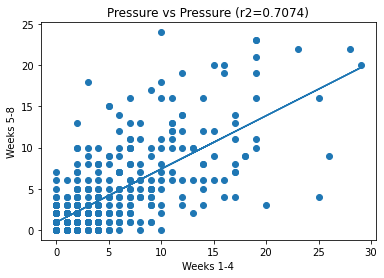

In [24]:
x = pressures_week[pressures_week['pressures_week1_4']==1]['pressure']
y = pressures_week[pressures_week['pressures_week1_4']==0]['pressure']
correlation = pearsonr(x,y)[0]
plt.scatter(x,y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)


plt.title('Pressure vs Pressure' + ' (r2=' + str(round(correlation,4))+')')
plt.xlabel('Weeks 1-4')
plt.ylabel('Weeks 5-8')

plt.show()

Looks like there's evidence that pressures in weeks 1-4 predict pressures in weeks 5-8 pretty well. This confirms prior research that shows that pressures are a stable metric.

### xPress vs Pressure

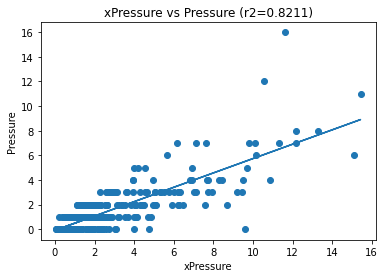

In [25]:
x = final_df['total_xPress']
y = final_df['total_press']

correlation = pearsonr(x,y)[0]
plt.scatter(x,y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)


plt.title('xPressure vs Pressure' + ' (r2=' + str(round(correlation,4))+')')
plt.xlabel('xPressure')
plt.ylabel('Pressure')

plt.show()

In [26]:
final_df[final_df['total_xPress']>final_df['total_xPress'].max()-5]

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack
13,37104.0,11.635880,16.0,Cameron Heyward,DT,199,3.0
44,41239.0,13.264069,8.0,Aaron Donald,DT,260,6.0
74,42403.0,10.568730,12.0,Randy Gregory,DE,146,5.0
92,43292.0,15.088937,6.0,Joey Bosa,OLB,179,4.0
95,43298.0,10.887217,4.0,Leonard Floyd,OLB,200,8.0
141,44813.0,12.155130,7.0,Myles Garrett,DE,208,12.0
144,44825.0,12.188631,8.0,Haason Reddick,OLB,188,8.0
151,44842.0,15.434910,11.0,T.J. Watt,OLB,155,8.0
244,47795.0,11.324327,7.0,Rashan Gary,OLB,196,5.0


In [27]:
final_df[final_df['total_press']>final_df['total_press'].max()-5]

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack
13,37104.0,11.63588,16.0,Cameron Heyward,DT,199,3.0
74,42403.0,10.56873,12.0,Randy Gregory,DE,146,5.0


While pressure was good at predicting iself week over week, the data gives evidence that xPressure does a better job at predicting pressure. This is promising for the metric.

### Sack vs Sack

In [28]:
plays['sack'] = np.where((plays['pff_sack']==1), 1, 0)
sacks_game = plays.groupby(['nflId','gameId']).sum()[['sack']].reset_index()
sacks_game = sacks_game.merge(games, on=['gameId'])[['nflId','gameId','sack','season','week']]
sacks_week = sacks_game.groupby(['nflId','week']).sum()[['sack']].reset_index()
sacks_week['sacks_week1_4'] = np.where((sacks_week['week'] == 1) | (sacks_week['week'] == 2) | (sacks_week['week'] == 3) | (sacks_week['week'] == 4),1,0)
sacks_week = sacks_week.groupby(['nflId','sacks_week1_4']).sum()[['sack']].reset_index()
sacks_week.head()

,nflId,sacks_week1_4,sack
0,33131,0,0
1,33131,1,0
2,34465,0,1
3,34465,1,0
4,34654,1,0


In [29]:
bothWeekSets = sacks_week.groupby('nflId').count()[['sacks_week1_4']].reset_index()
bothWeekSets = bothWeekSets[bothWeekSets['sacks_week1_4']>1]['nflId'].tolist()
sacks_week = sacks_week[sacks_week['nflId'].isin(bothWeekSets)]

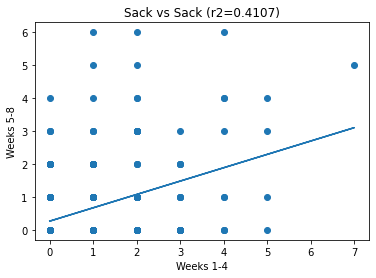

In [30]:
x = sacks_week[sacks_week['sacks_week1_4']==1]['sack']
y = sacks_week[sacks_week['sacks_week1_4']==0]['sack']
correlation = pearsonr(x,y)[0]
plt.scatter(x,y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)


plt.title('Sack vs Sack' + ' (r2=' + str(round(correlation,4))+')')
plt.xlabel('Weeks 1-4')
plt.ylabel('Weeks 5-8')

plt.show()

The above graph gives evidence that sacks are not as stable as pressures.

### xPress vs Sack

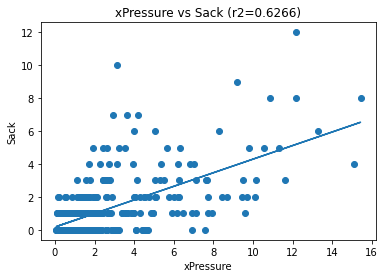

In [31]:
x = final_df['total_xPress']
y = final_df['pff_sack']

correlation = pearsonr(x,y)[0]
plt.scatter(x,y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)


plt.title('xPressure vs Sack' + ' (r2=' + str(round(correlation,4))+')')
plt.xlabel('xPressure')
plt.ylabel('Sack')

plt.show()

This gives evidence that xPress does a much better job at predicting sacks than sacks itself. Another point for the metric.

### xPress vs xPress

Now that I've given evidence at this metric performing than what we currently have, I'll see if this is a stable metric.

In [32]:
# go back and use the average xPress per play
avg_xpress.head()

,gameId,nflId,playId,avg_xPress,avg_press
0,2021090900,34777.0,282,0.056998,0.0
1,2021090900,34777.0,788,0.086247,0.0
2,2021090900,34777.0,1078,0.092580,0.0
3,2021090900,34777.0,1918,0.117529,0.0
4,2021090900,34777.0,2656,0.155658,0.0


In [33]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


In [34]:
avg_xpress.shape

(5417, 5)

In [35]:
xpress_game = avg_xpress.merge(games, on='gameId')
# sanity check (27602)
print(xpress_game.shape)

xpress_game = xpress_game.groupby(by=['nflId','week']).sum().reset_index()[['nflId','week','gameId','playId','avg_xPress']].rename(columns={'avg_xPress':'xPress'})
xpress_game['xpress_game1_4'] = np.where((xpress_game['week'] == 1) | (xpress_game['week'] == 2) | (xpress_game['week'] == 3) | (xpress_game['week'] == 4),1,0)
xpress_game = xpress_game.groupby(by=['nflId','xpress_game1_4']).sum().reset_index()[['nflId','xpress_game1_4','xPress']]

(5417, 11)


In [36]:
bothWeekSets = xpress_game.groupby('nflId').count()[['xpress_game1_4']].reset_index()
bothWeekSets = bothWeekSets[bothWeekSets['xpress_game1_4']>1]['nflId'].tolist()
xpress_game = xpress_game[xpress_game['nflId'].isin(bothWeekSets)]
xpress_game = xpress_game.merge(players, on=['nflId'])

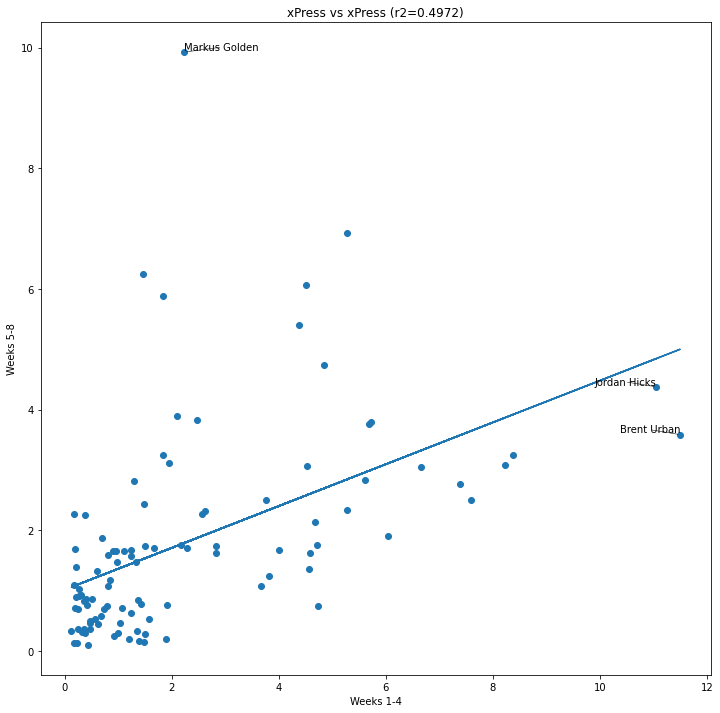

In [37]:
from adjustText import adjust_text
plt.figure(figsize=(12,12))
x = xpress_game[xpress_game['xpress_game1_4']==1].reset_index()['xPress']
y = xpress_game[xpress_game['xpress_game1_4']==0].reset_index()['xPress']
correlation = pearsonr(x,y)[0]
plt.scatter(x,y)
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
#add linear regression line to scatterplot 
plt.plot(x, m*x+b)


plt.title('xPress vs xPress' + ' (r2=' + str(round(correlation,4))+')')
plt.xlabel('Weeks 1-4')
plt.ylabel('Weeks 5-8')

texts = []
for index in range(len(x)):
    if (x[index] > x.max()*0.95) | (y[index] > y.max()*0.95):
        # plt.text(x[index], y[index], str(xpress_game.reset_index()['displayName'].loc[index]), size=10)
        texts.append(plt.text(x[index], y[index], str(xpress_game.reset_index()['displayName'].loc[index])))
    
    
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.show()

Using data from weeks 1-4 as one set of data and 5-8 as another, this visual gives evidence that xPress has stability week over week.

## Metric Performance

Now that I've shown that the model performs well compared to actual pressures, I'll see if the model returns players typically near the top of pass rusher statisitcs.

In [38]:
final_df['xPoE'] = final_df['total_press']-final_df['total_xPress']
final_df.head()

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack,xPoE
0,34465.0,1.873433,1.0,Malcolm Jenkins,SS,25,1.0,-0.873433
1,34777.0,1.295632,0.0,Steve McLendon,NT,53,0.0,-1.295632
2,35441.0,5.757794,3.0,Ndamukong Suh,DE,211,2.0,-2.757794
3,35449.0,4.115837,1.0,Tyson Alualu,DE,36,0.0,-3.115837
4,35454.0,4.492294,2.0,Jason Pierre-Paul,DE,183,2.0,-2.492294


### xPress

In [55]:
# plotting functions
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

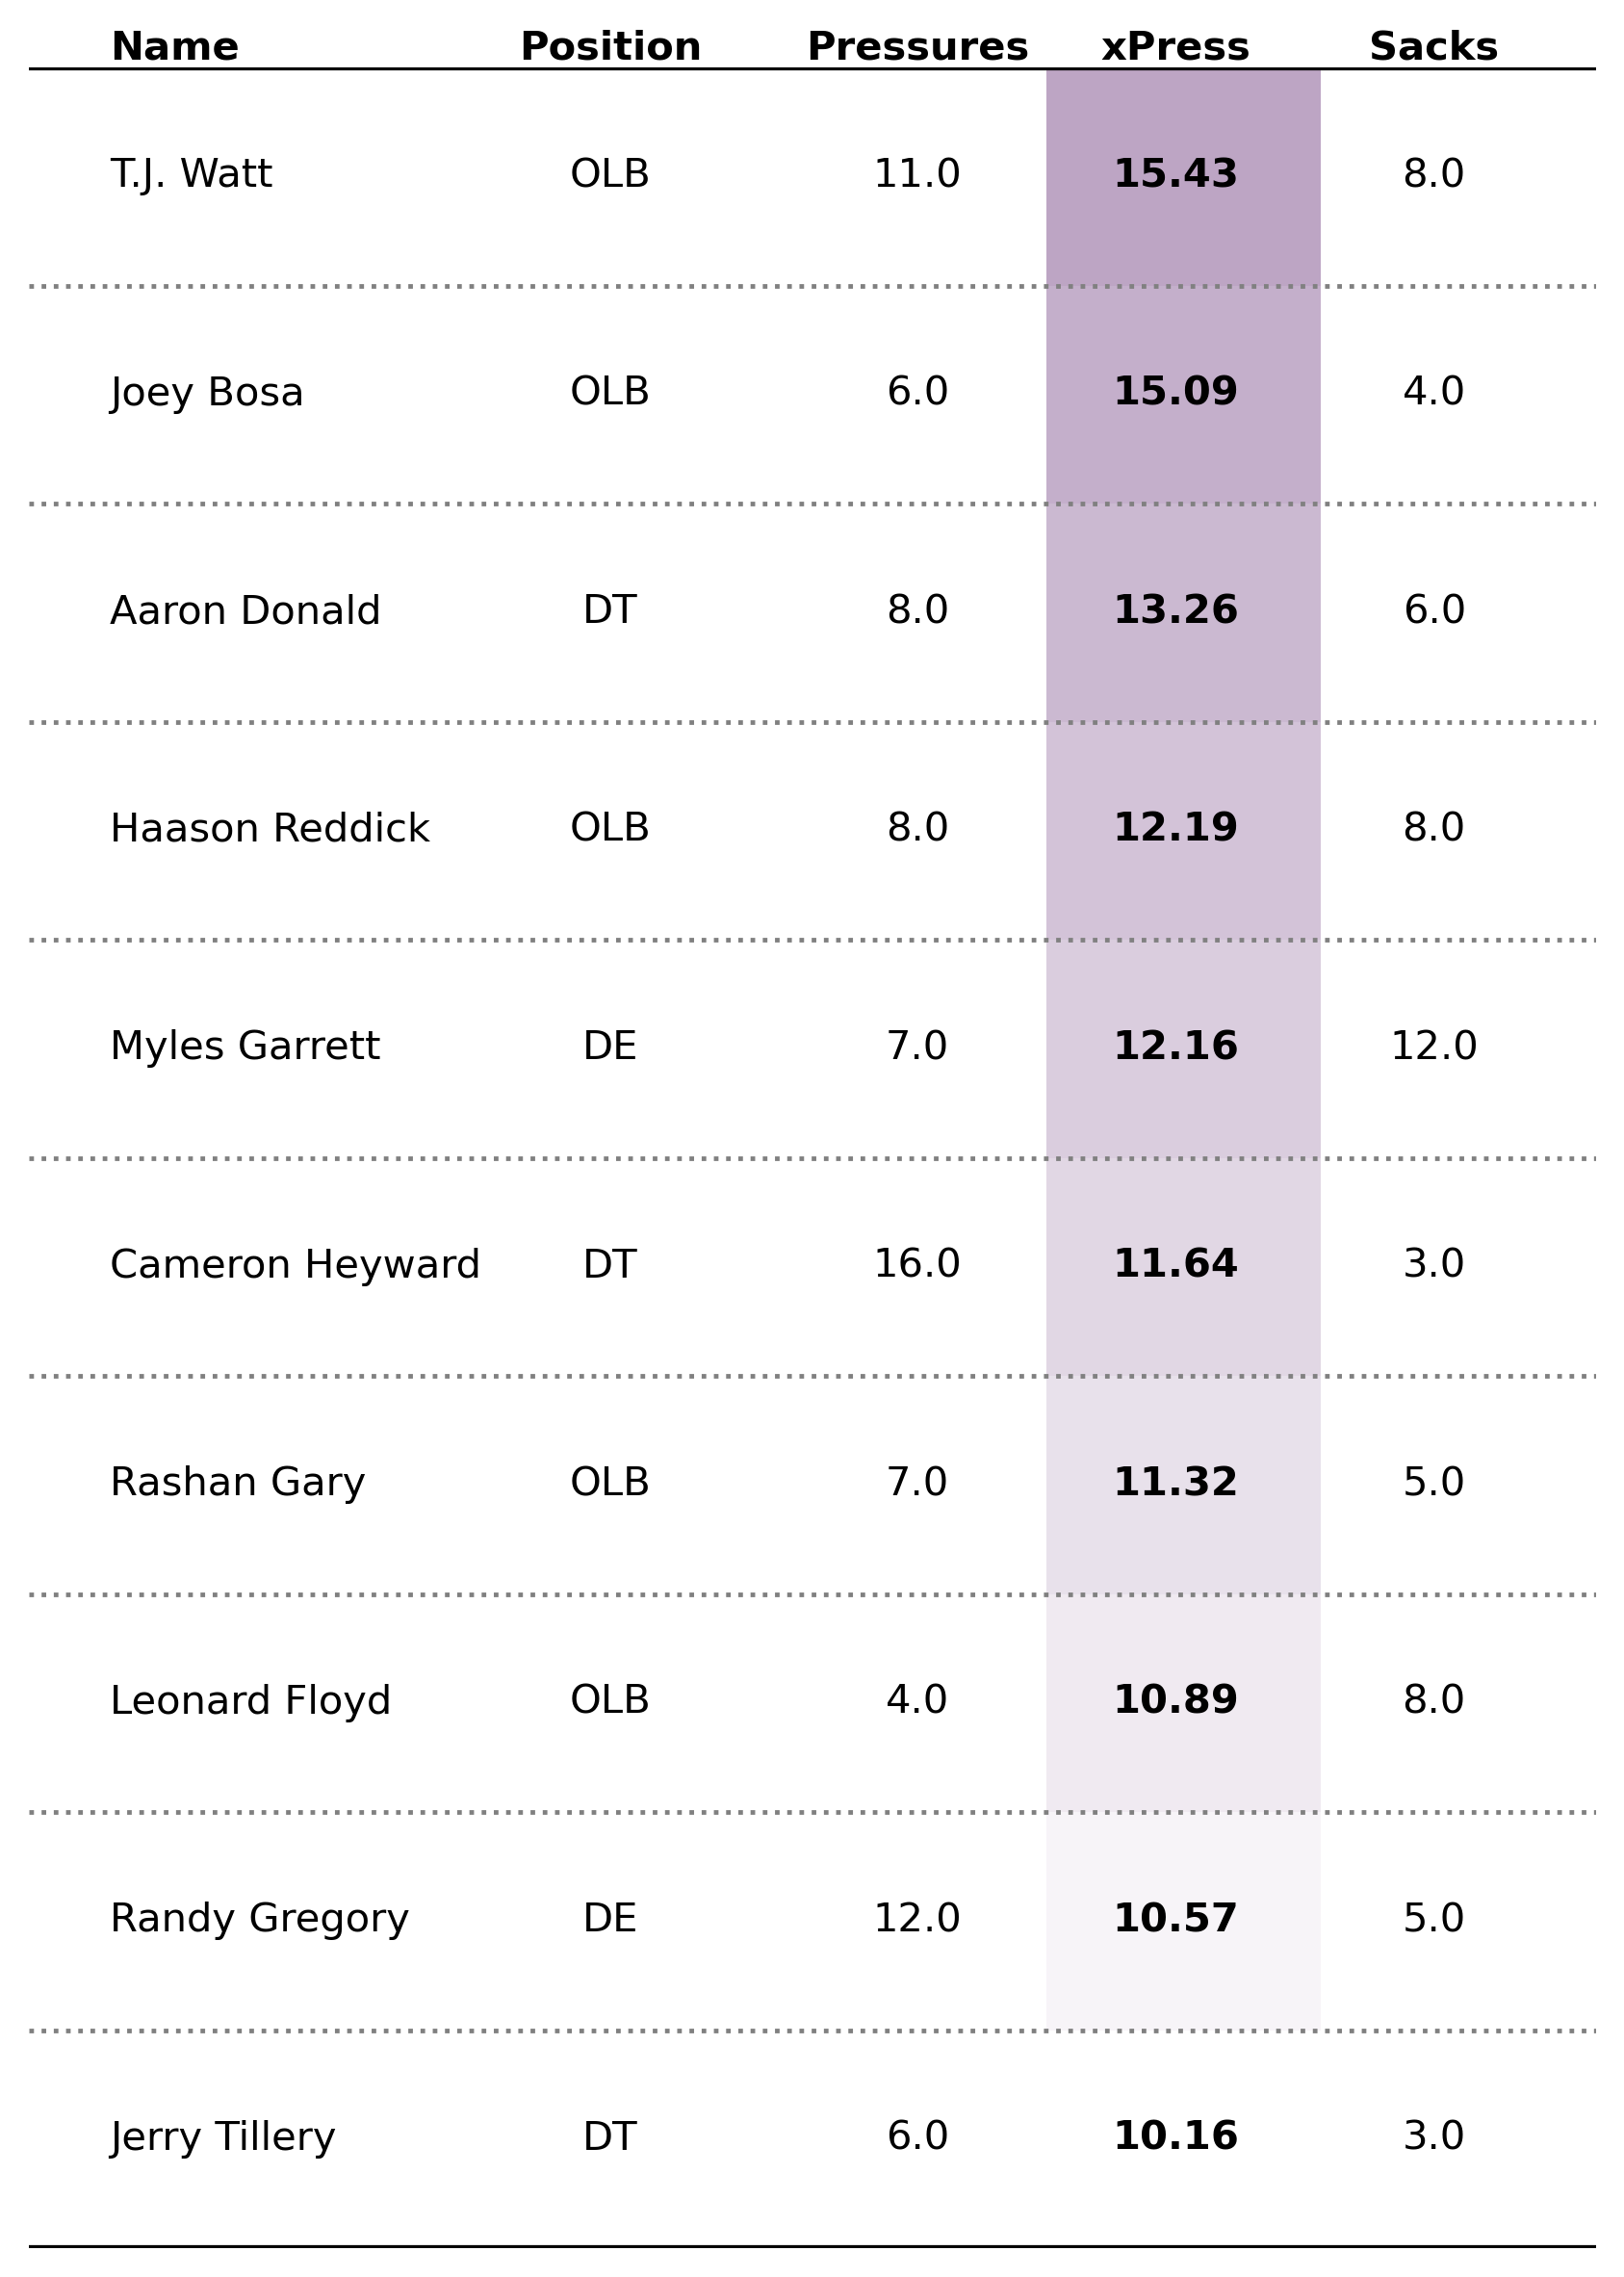

In [100]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
plotting_df = final_df[final_df['snaps']>100].sort_values(by='total_xPress')[['displayName',
                                                                                'officialPosition',
                                                                                'total_press',
                                                                                'total_xPress',
                                                                               'pff_sack']].tail(10).reset_index()


color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 5
nrows = plotting_df.shape[0]

ax.set_xlim(0, ncols-.15)
ax.set_ylim(0, nrows)

positions = [0.25, 1.8, 2.75, 3.55, 4.35]
columns = ['displayName','officialPosition','total_press','total_xPress','pff_sack']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'total_xPress':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Name','Position','Pressures','xPress','Sacks']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[3.15,4],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    'C:/Users/19012/Documents/BDB 2023/all_xpress.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)

In [102]:
edge = final_df[(final_df['snaps']>100) & (final_df['officialPosition']=='DE')]
edge.sort_values(by='total_xPress',ascending=False)

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack,xPoE
141,44813.0,12.16,7.0,Myles Garrett,DE,208,12.0,-5.155130
74,42403.0,10.57,12.0,Randy Gregory,DE,146,5.0,1.431270
245,47799.0,9.78,7.0,Brian Burns,DE,202,5.0,-2.777369
163,44892.0,9.59,0.0,Tarell Basham,DE,144,1.0,-9.590039
161,44886.0,8.46,4.0,Chris Wormley,DE,161,2.0,-4.456619
213,46204.0,7.68,4.0,John Franklin-Myers,DE,167,3.0,-3.681495
42,41227.0,6.30,3.0,Jadeveon Clowney,DE,172,5.0,-3.297176
12,37097.0,6.27,3.0,Cameron Jordan,DE,224,2.0,-3.267123
347,53053.0,6.24,2.0,Bryce Huff,DE,135,4.0,-4.240015
149,44838.0,5.99,3.0,Takkarist McKinley,DE,120,2.0,-2.990665


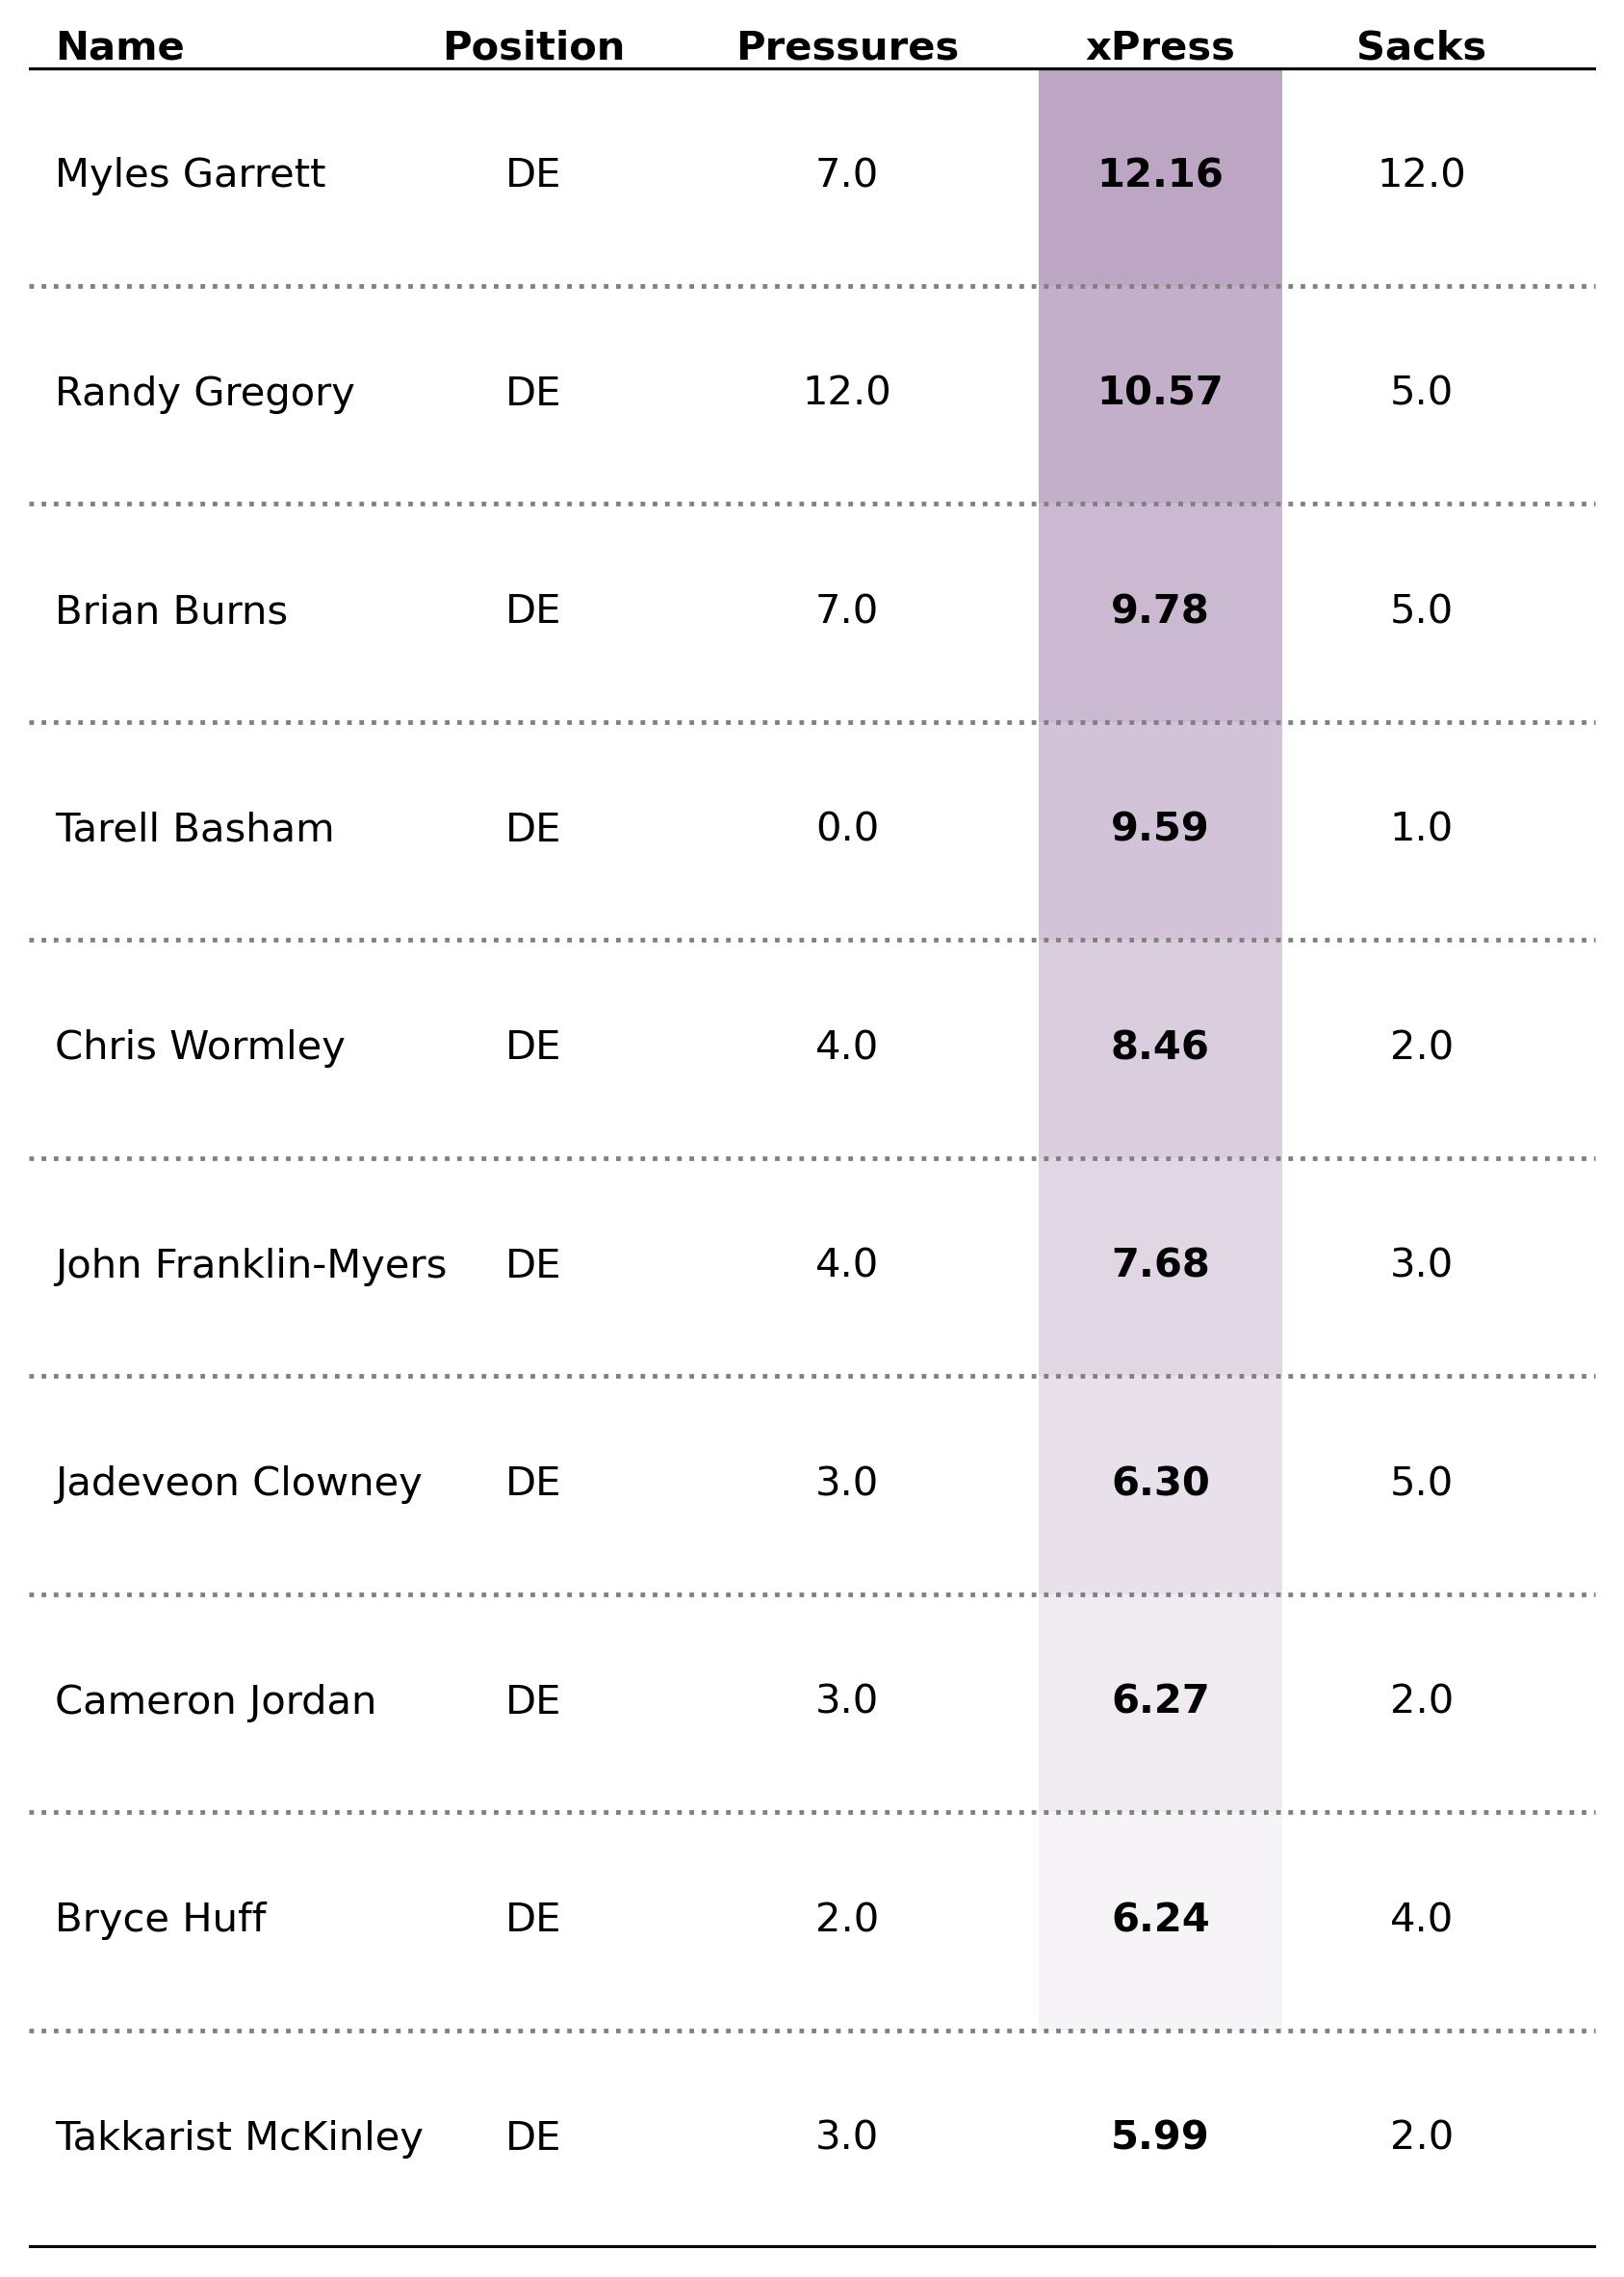

In [124]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
plotting_df = edge.sort_values(by='total_xPress')[['displayName',
                                                    'officialPosition',
                                                    'total_press',
                                                    'total_xPress',
                                                   'pff_sack']].tail(10).reset_index()




color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 5
nrows = plotting_df.shape[0]

ax.set_xlim(0, ncols-.5)
ax.set_ylim(0, nrows)

positions = [0.075, 1.45, 2.35, 3.25, 4]
columns = ['displayName','officialPosition','total_press','total_xPress','pff_sack']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'total_xPress':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Name','Position','Pressures','xPress','Sacks']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[2.9,3.6],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    'C:/Users/19012/Documents/BDB 2023/edge_xpress.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)

In [125]:
interior = final_df[(final_df['snaps']>100) & (final_df['officialPosition']=='DT')]
interior.sort_values(by='total_xPress',ascending=False)

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack,xPoE
44,41239.0,13.26,8.0,Aaron Donald,DT,260,6.0,-5.264069
13,37104.0,11.64,16.0,Cameron Heyward,DT,199,3.0,4.364120
249,47811.0,10.16,6.0,Jerry Tillery,DT,189,3.0,-4.157292
362,53504.0,9.52,4.0,Osa Odighizuwa,DT,176,3.0,-5.523926
26,38667.0,7.73,4.0,Malik Jackson,DT,194,1.0,-3.729411
153,44847.0,7.72,3.0,Malik McDowell,DT,159,2.0,-4.720525
355,53467.0,6.91,4.0,Christian Barmore,DT,185,1.0,-2.907653
65,42349.0,5.07,3.0,Leonard Williams,DT,245,6.0,-2.074186
294,52415.0,5.07,2.0,Derrick Brown,DT,159,2.0,-3.073181
82,42480.0,4.93,4.0,Grady Jarrett,DT,185,1.0,-0.933167


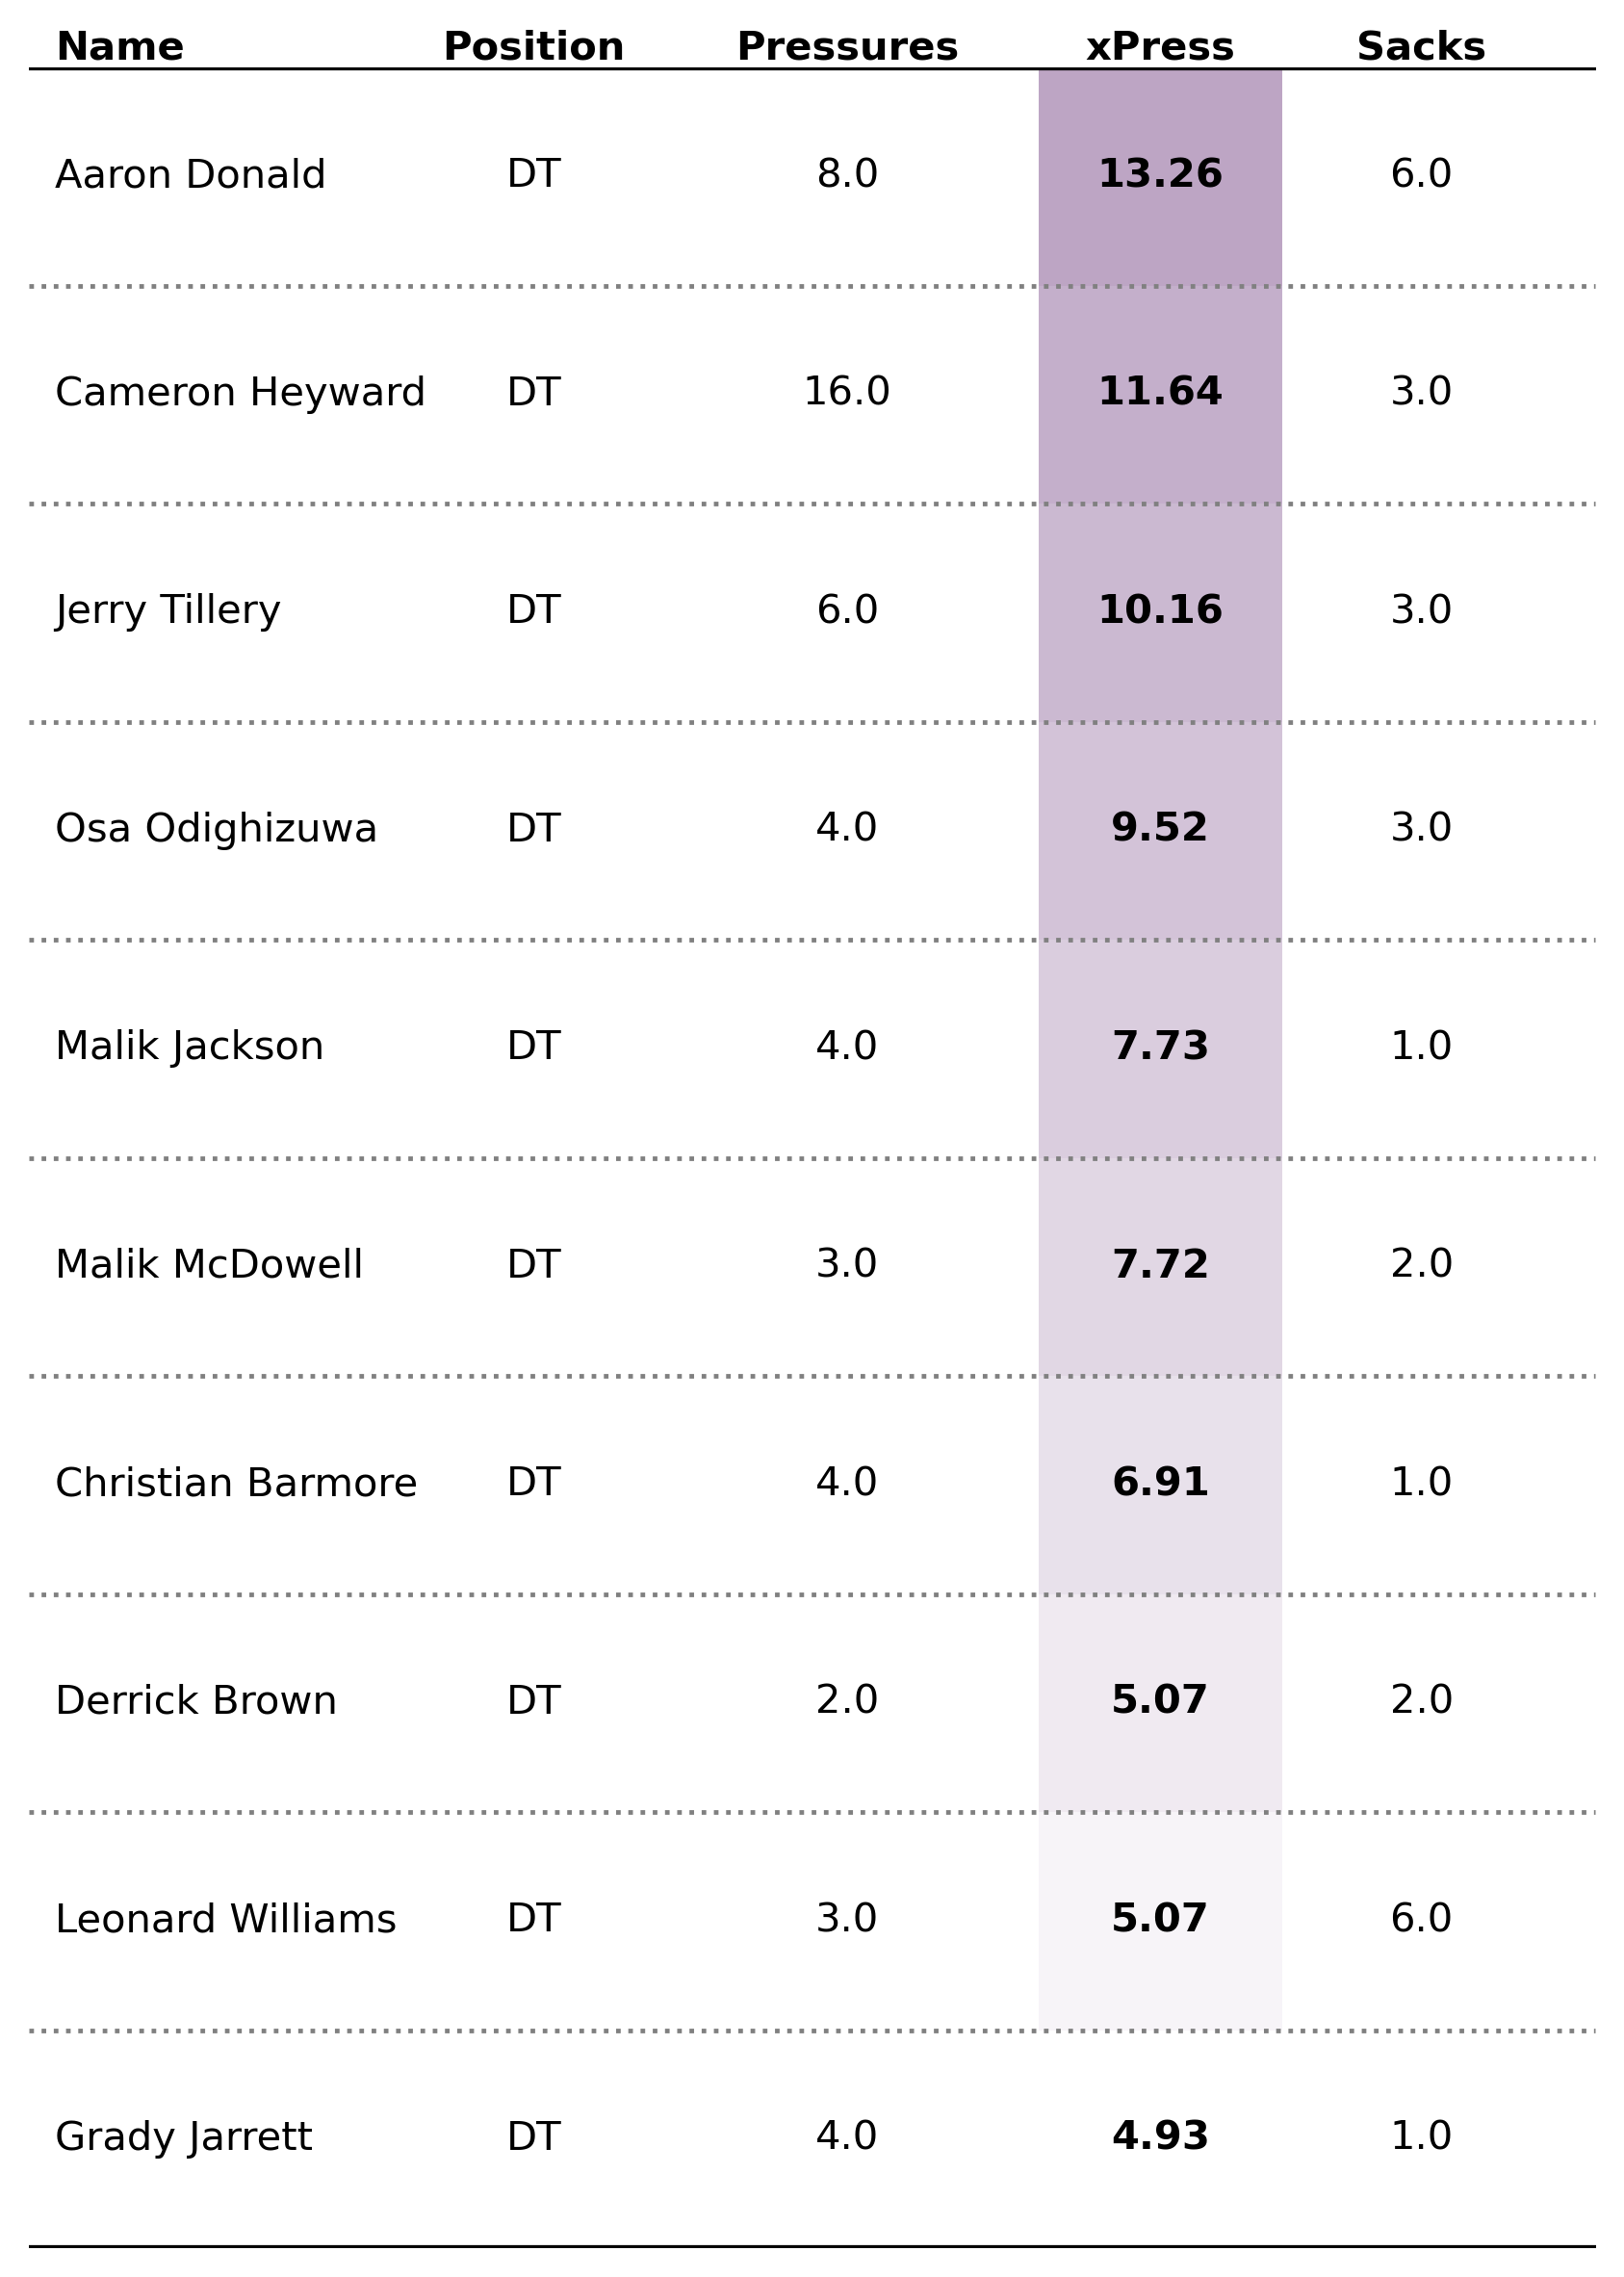

In [126]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
plotting_df = interior.sort_values(by='total_xPress')[['displayName',
                                                    'officialPosition',
                                                    'total_press',
                                                    'total_xPress',
                                                   'pff_sack']].tail(10).reset_index()




color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 5
nrows = plotting_df.shape[0]

ax.set_xlim(0, ncols-.5)
ax.set_ylim(0, nrows)

positions = [0.075, 1.45, 2.35, 3.25, 4]
columns = ['displayName','officialPosition','total_press','total_xPress','pff_sack']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'total_xPress':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Name','Position','Pressures','xPress','Sacks']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[2.9,3.6],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    'C:/Users/19012/Documents/BDB 2023/interior_xpress.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)

### xPoE

In [137]:
xpoe = final_df[final_df['snaps']>100]#.sort_values(by='xPoE',ascending=False)

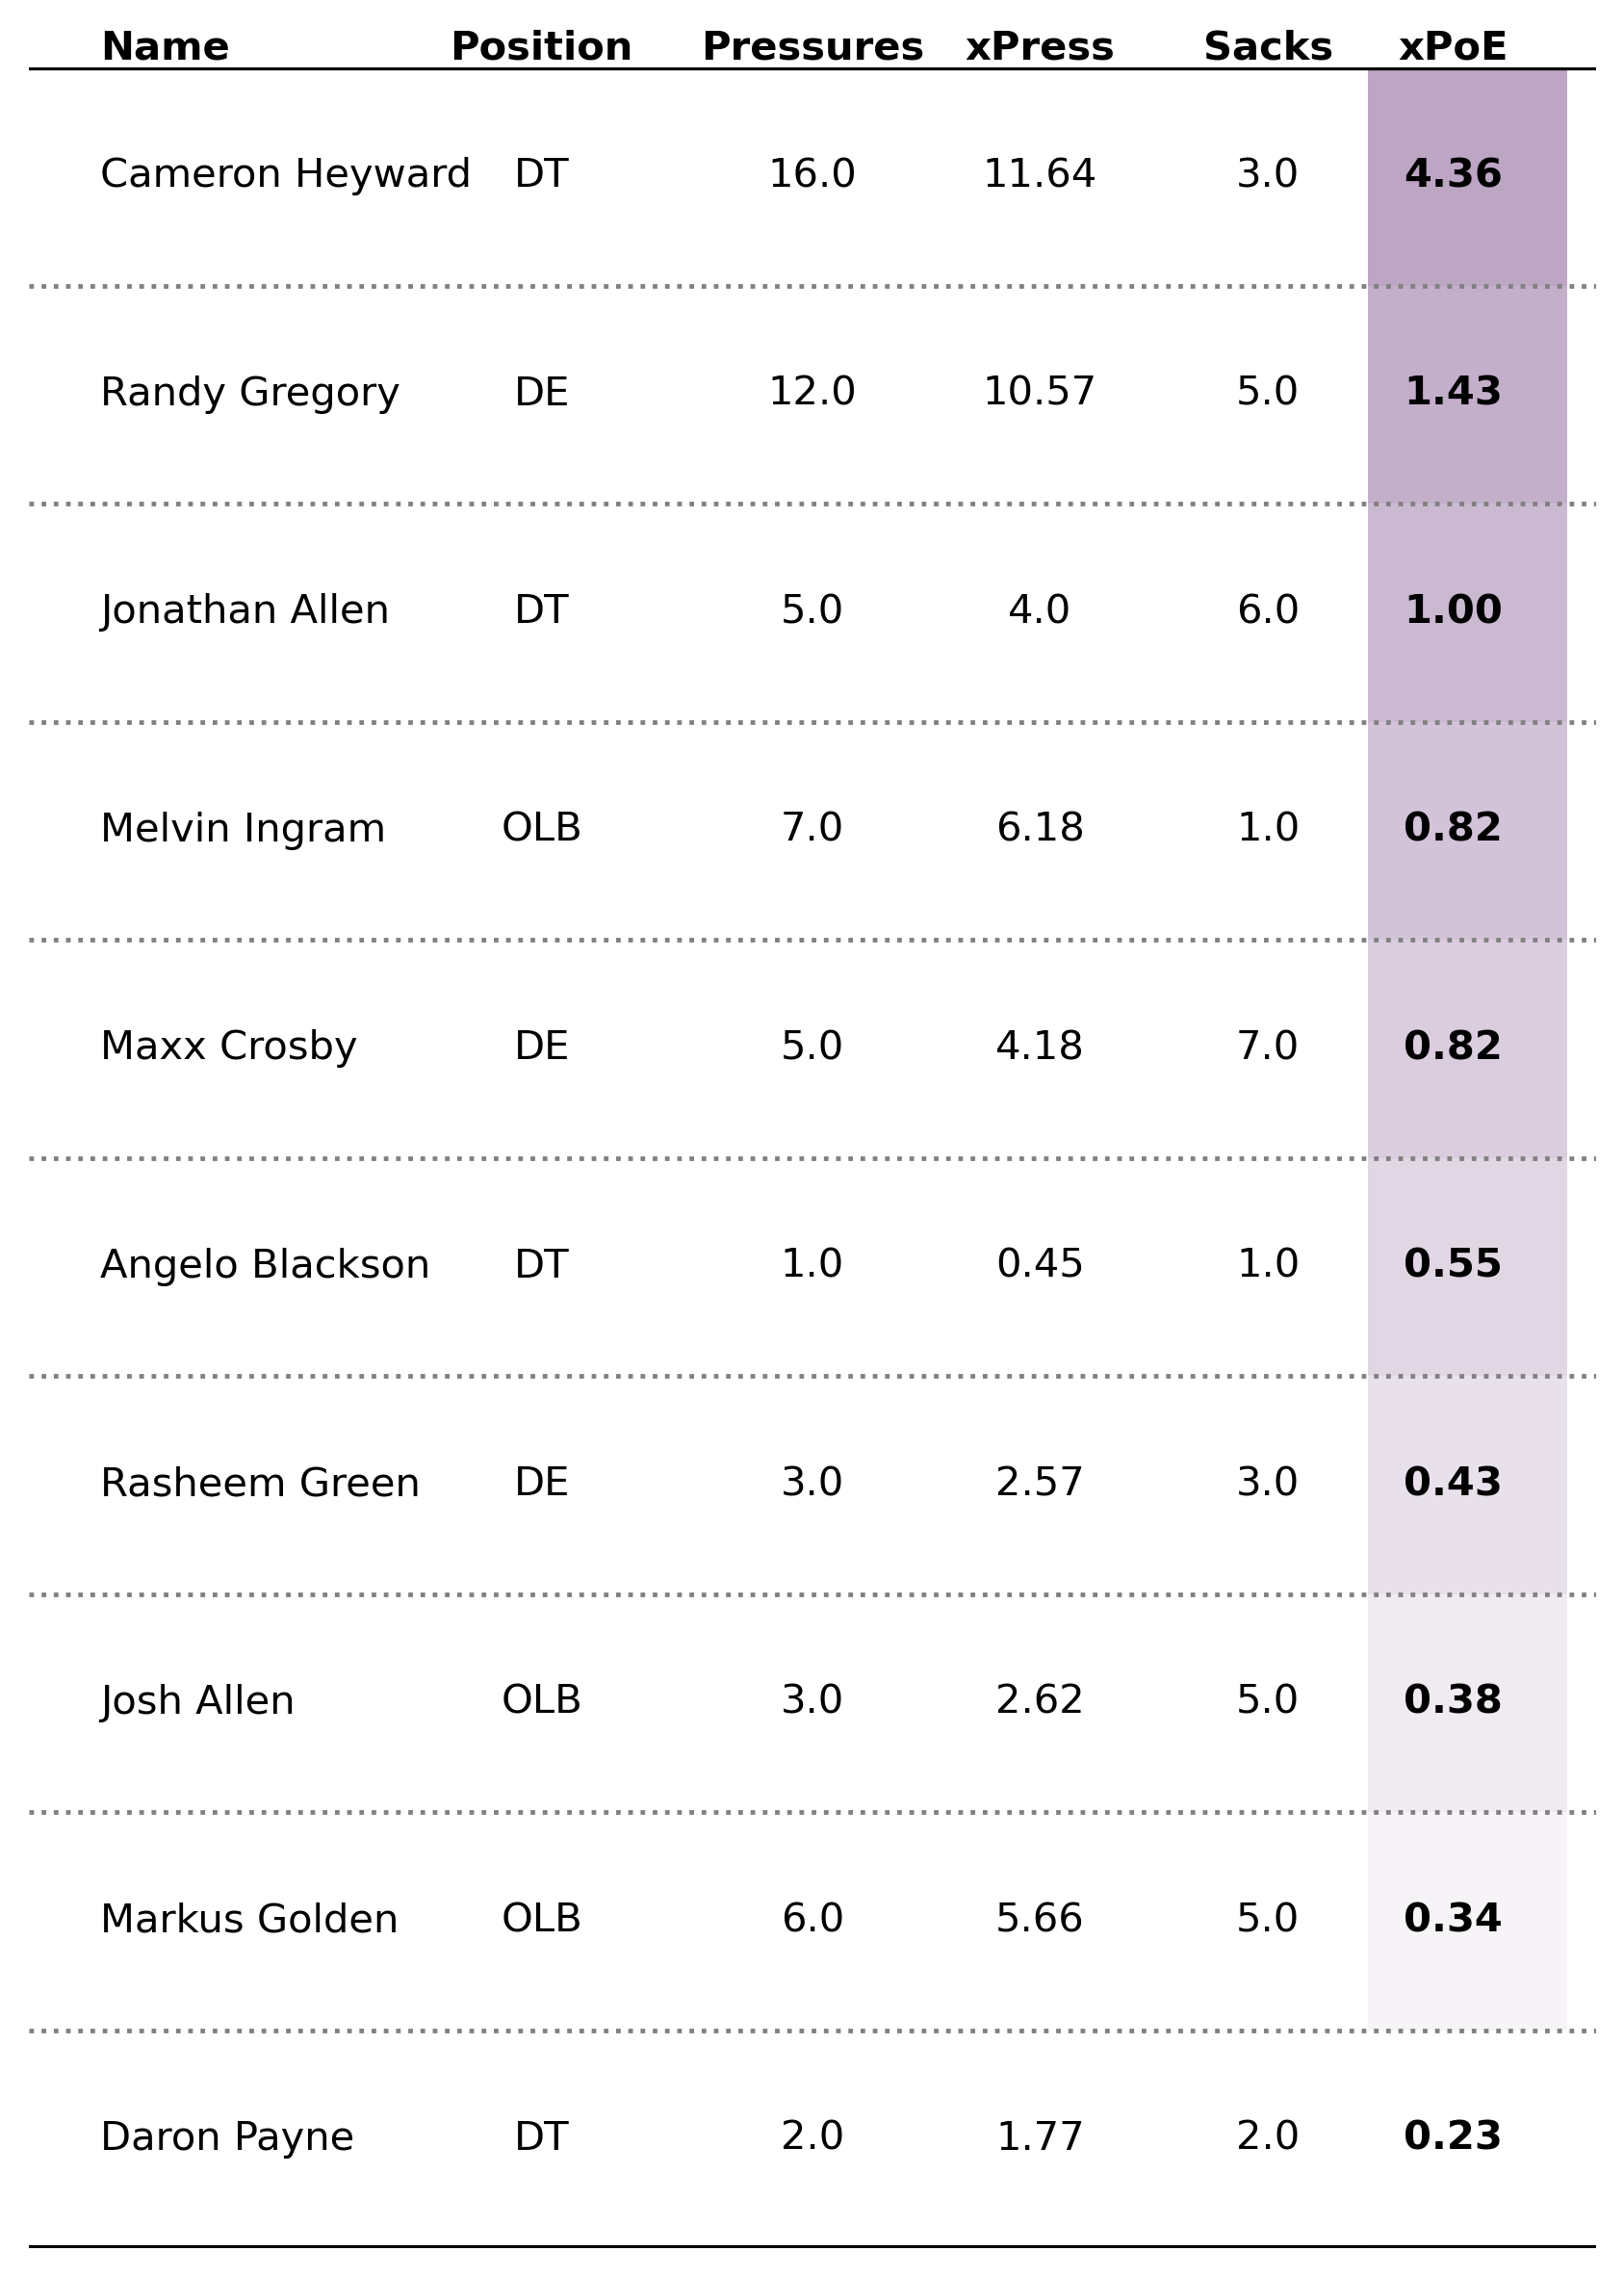

In [139]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
plotting_df = xpoe[xpoe['snaps']>100].sort_values(by='xPoE')[['displayName',
                                                                                'officialPosition',
                                                                                'total_press',
                                                                                'total_xPress',
                                                                               'pff_sack',
                                                                             'xPoE']].tail(10).reset_index()


color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 5
nrows = plotting_df.shape[0]

ax.set_xlim(0, ncols+0.5)
ax.set_ylim(0, nrows)

positions = [0.25, 1.8, 2.75, 3.55, 4.35, 5]
columns = ['displayName','officialPosition','total_press','total_xPress','pff_sack','xPoE']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'xPoE':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Name','Position','Pressures','xPress','Sacks','xPoE']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[4.7,5.4],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    'C:/Users/19012/Documents/BDB 2023/xpoe_overperform.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)

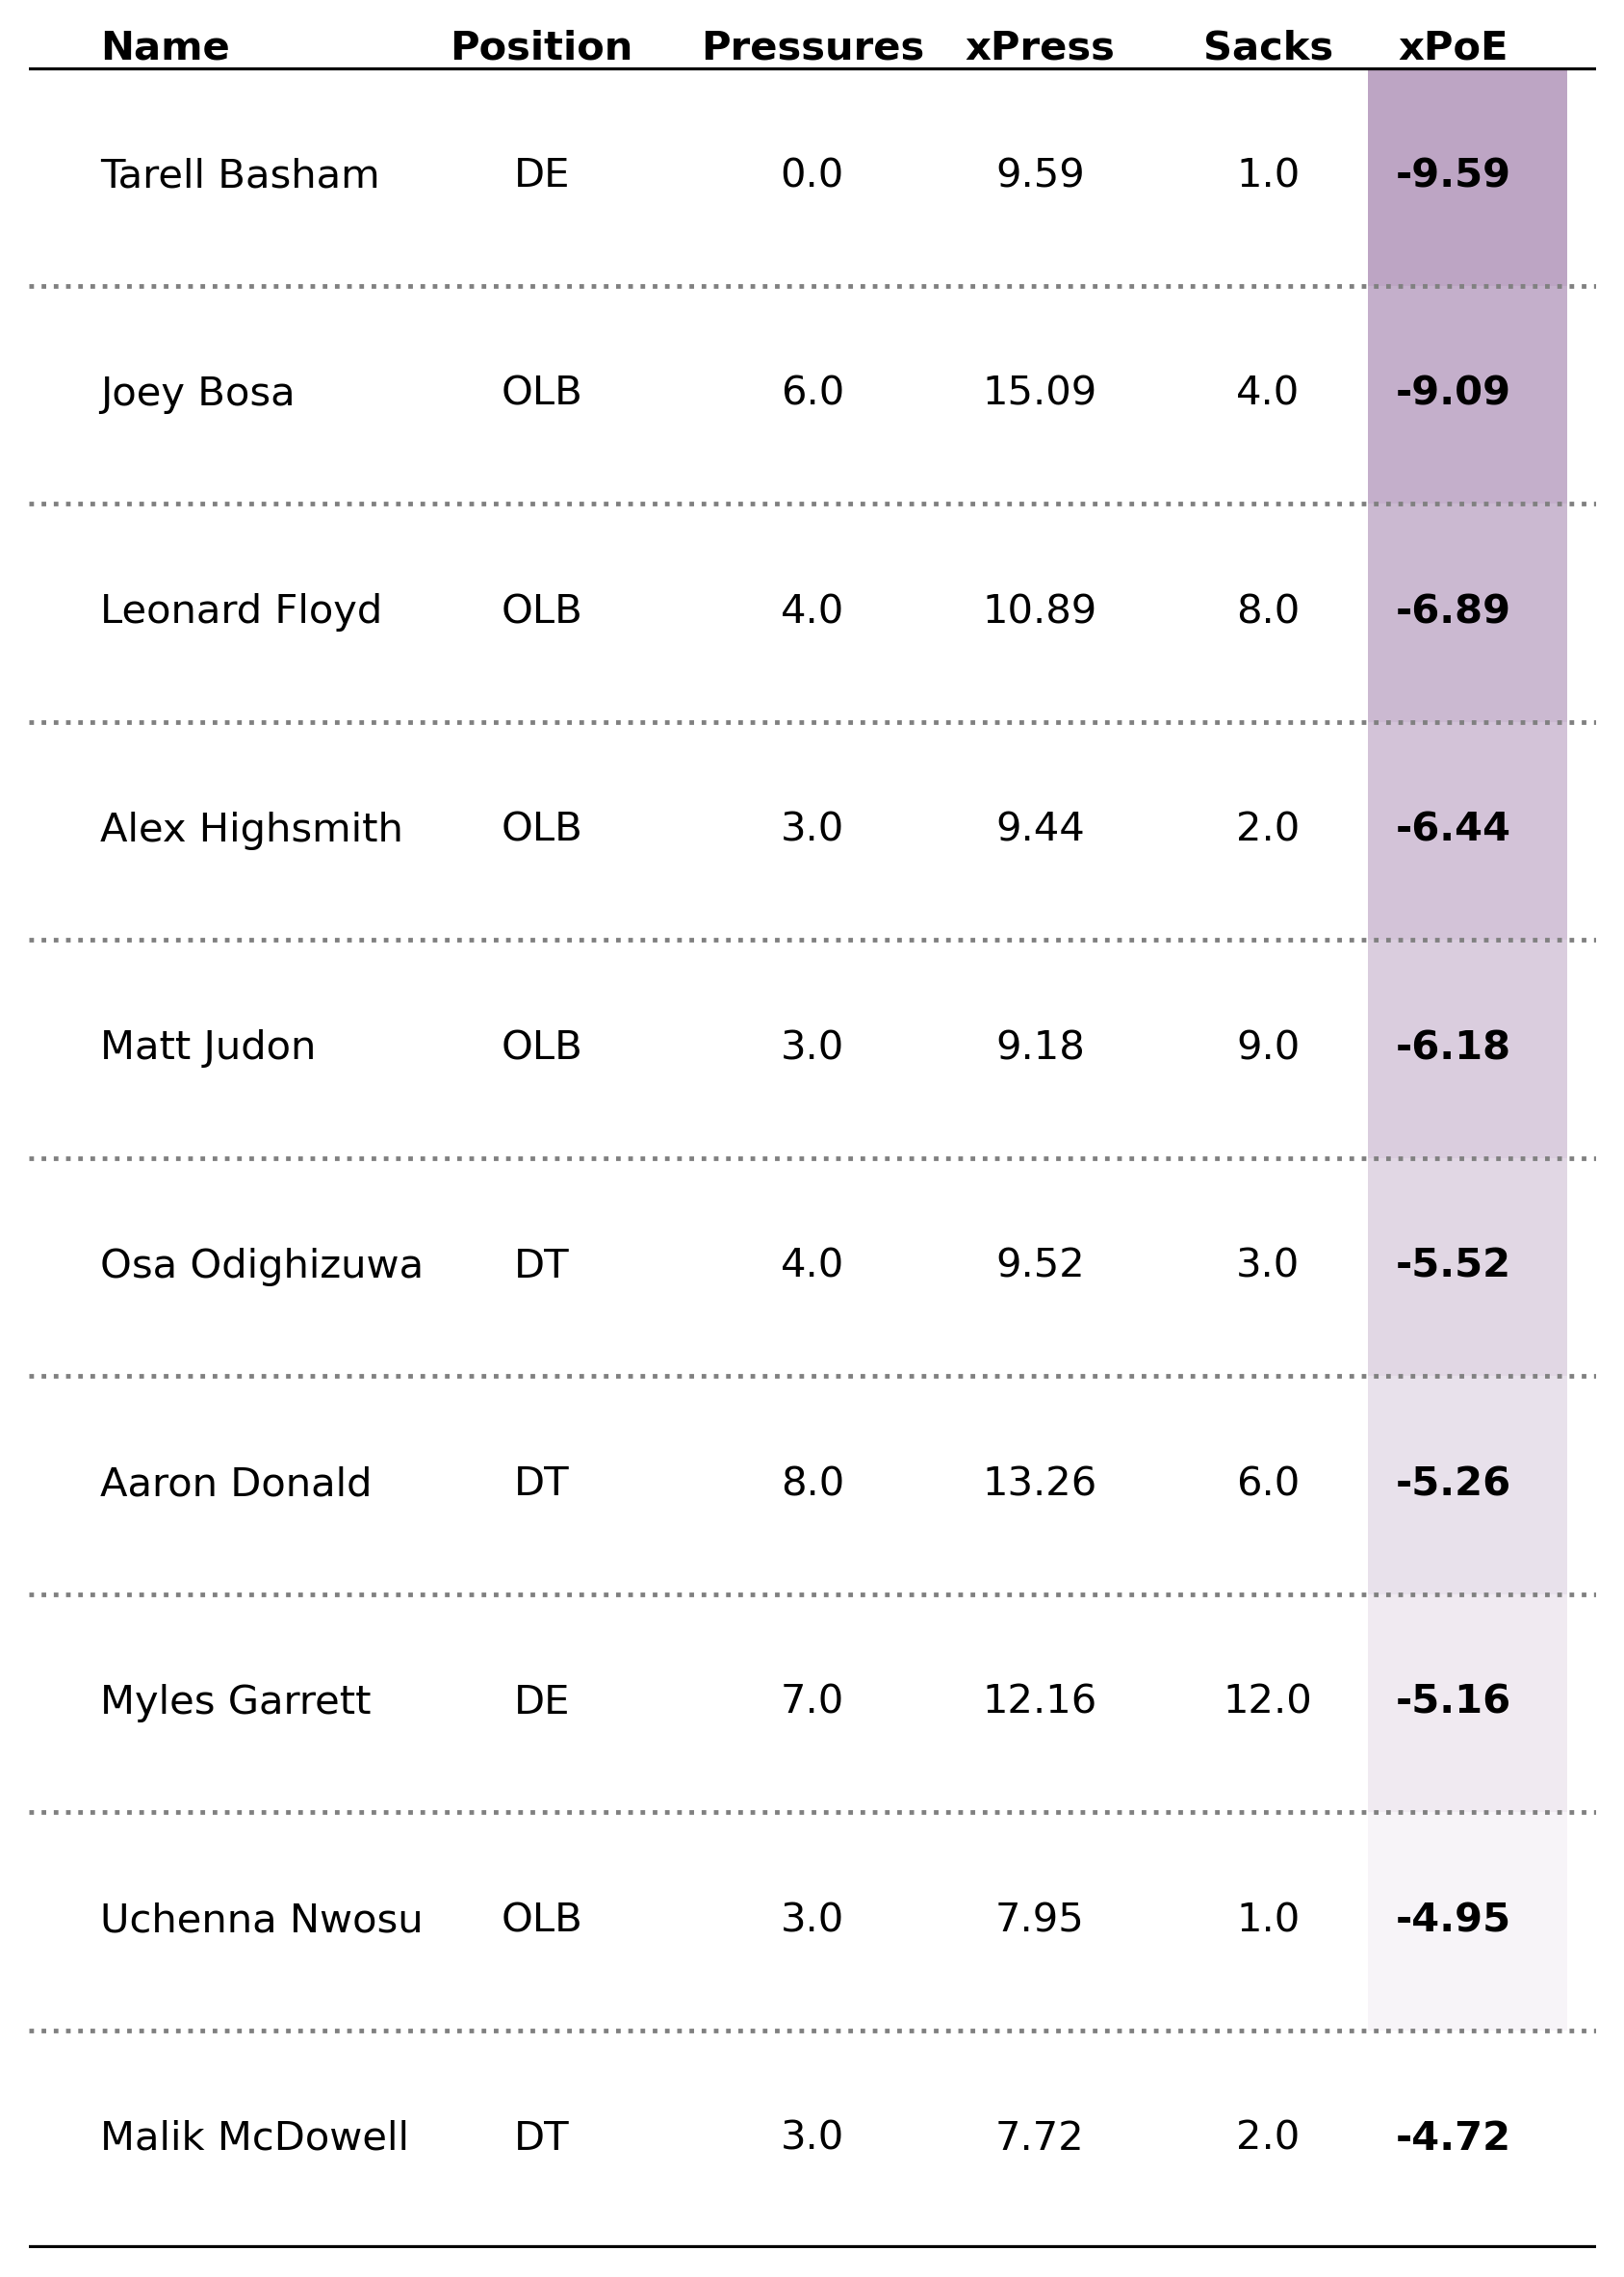

In [147]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
plotting_df = xpoe[xpoe['snaps']>100].sort_values(by='xPoE',ascending=False)[['displayName',
                                                                                'officialPosition',
                                                                                'total_press',
                                                                                'total_xPress',
                                                                               'pff_sack',
                                                                             'xPoE']].tail(10).reset_index().sort_values(by='xPoE',ascending=False)


color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 5
nrows = plotting_df.shape[0]

ax.set_xlim(0, ncols+0.5)
ax.set_ylim(0, nrows)

positions = [0.25, 1.8, 2.75, 3.55, 4.35, 5]
columns = ['displayName','officialPosition','total_press','total_xPress','pff_sack','xPoE']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'xPoE':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Name','Position','Pressures','xPress','Sacks','xPoE']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[4.7,5.4],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    'C:/Users/19012/Documents/BDB 2023/xpoe_underperform.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)

In [38]:
edge = final_df[(final_df['snaps']>100) & (final_df['officialPosition']=='DE')]
edge.sort_values(by='xPoE',ascending=False)

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack,xPoE
74,42403.0,10.568730,12.0,Randy Gregory,DE,146,5.0,1.431270
264,47889.0,4.178987,5.0,Maxx Crosby,DE,218,7.0,0.821013
202,46148.0,2.567244,3.0,Rasheem Green,DE,198,3.0,0.432756
10,37084.0,3.932216,4.0,J.J. Watt,DE,188,1.0,0.067784
237,47785.0,2.939084,3.0,Nick Bosa,DE,168,7.0,0.060916
35,40074.0,1.942265,2.0,William Gholston,DE,124,2.0,0.057735
166,44915.0,3.121853,3.0,Trey Hendrickson,DE,216,10.0,-0.121853
59,41786.0,2.170532,2.0,Kerry Hyder,DE,168,1.0,-0.170532
5,35470.0,2.616597,2.0,Jerry Hughes,DE,134,1.0,-0.616597
16,37841.0,1.708806,1.0,Mario Addison,DE,114,2.0,-0.708806


In [39]:
interior = final_df[(final_df['snaps']>100) & (final_df['officialPosition']=='DT')]
interior.sort_values(by='xPoE',ascending=False)

,nflId,total_xPress,total_press,displayName,officialPosition,snaps,pff_sack,xPoE
13,37104.0,11.635880,16.0,Cameron Heyward,DT,199,3.0,4.364120
146,44829.0,3.995779,5.0,Jonathan Allen,DT,218,6.0,1.004221
78,42443.0,0.445107,1.0,Angelo Blackson,DT,112,1.0,0.554893
185,46082.0,1.771091,2.0,Daron Payne,DT,233,2.0,0.228909
53,41341.0,3.934611,4.0,DaQuan Jones,DT,133,1.0,0.065389
197,46138.0,2.537747,2.0,B.J. Hill,DT,136,3.0,-0.537747
126,43436.0,1.555288,1.0,Quinton Jefferson,DT,161,3.0,-0.555288
171,44957.0,0.611975,0.0,Grover Stewart,DT,137,1.0,-0.611975
242,47792.0,1.867999,1.0,Ed Oliver,DT,145,1.0,-0.867999
82,42480.0,4.933167,4.0,Grady Jarrett,DT,185,1.0,-0.933167


## Player sample vs Average

This will show that we aren't just assigning every player the average value.

In [40]:
frame_avg = press_pred.groupby(by=['frameId']).mean()[['xPress']].reset_index()
frame_avg = frame_avg[(frame_avg['frameId']>=6) & (frame_avg['frameId']<=20)]
frame_avg['displayName'] = 'avg'

In [41]:
player_frame_avg = press_pred.groupby(by=['nflId','frameId']).mean()[['xPress']].reset_index()
player_frame_avg = player_frame_avg[(player_frame_avg['nflId']==44813) | (player_frame_avg['nflId']==42375) | (player_frame_avg['nflId']==41239)]
player_frame_avg = player_frame_avg[(player_frame_avg['frameId']>=6) & (player_frame_avg['frameId']<=20)]
player_frame_avg = player_frame_avg.merge(players,on='nflId')[['frameId','xPress','displayName']]

In [42]:
avg_player = frame_avg.append(player_frame_avg)

In [43]:
avg_player.set_index('frameId', inplace=True)

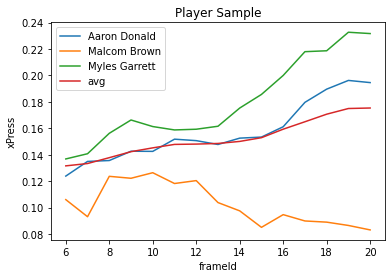

In [44]:
avg_player.groupby('displayName')['xPress'].plot(legend=True)
plt.title('Player Sample')
plt.ylabel('xPress')


plt.show()

## Feature Importance

Find averages for some of the important features.

### Dis

In [45]:
press_pred.head()

,Unnamed: 0,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,dist_qb,num_rushers,distance_blocker,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress,pressure
0,0,2021090900,41263.0,97,6,0.96,0.90,0.11,3,2,6.0,0,43.30,18.89,7.802083,5.0,3.263817,-1.74,316.48,288.76,1,0,0,0.130755,1
1,1,2021090900,41263.0,97,7,1.08,0.86,0.12,3,2,6.0,0,43.19,18.91,7.766557,5.0,3.172381,-1.74,308.13,282.13,1,0,0,0.140255,1
2,2,2021090900,41263.0,97,8,1.30,0.85,0.16,3,2,6.0,0,43.03,18.93,7.695193,5.0,3.059412,-1.74,310.58,277.08,1,0,0,0.139984,1
3,3,2021090900,41263.0,97,9,1.48,0.79,0.17,3,2,6.0,0,42.87,18.98,7.603138,5.0,2.943739,-1.74,312.75,279.62,1,0,0,0.161547,1
4,4,2021090900,41263.0,97,10,2.16,1.34,0.30,3,2,6.0,0,42.60,19.09,7.404627,5.0,2.695199,-1.74,312.75,286.29,1,0,0,0.111408,1


In [46]:
total_dis = press_pred.groupby(by=['gameId','nflId','playId']).sum()[['dis','pressure']].reset_index()
pressure_no_dis = total_dis[total_dis['pressure']==0][['dis']].mean()
pressure_dis = total_dis[total_dis['pressure']>=1][['dis']].mean()
print(pressure_no_dis)
print(pressure_dis)

dis    7.122001
dtype: float64
dis    11.039474
dtype: float64


Rushers travel about a yard more per play on pressures than not. 

### Dist to QB

In [47]:
press_pred = press_pred[press_pred['dist_qb'].notna()]
total_dis = press_pred.groupby(by=['gameId','nflId','playId']).mean()[['dist_qb','pressure']].reset_index()
pressure_no_dis = total_dis[total_dis['pressure']==0][['dist_qb']].mean()
pressure_dis = total_dis[total_dis['pressure']>=1][['dist_qb']].mean()
print(pressure_no_dis)
print(pressure_dis)

dist_qb    5.746776
dtype: float64
dist_qb    4.951006
dtype: float64


Average distance to QB is about a yard closer for rushers who get pressures

### Dist to LOS

In [48]:
press_pred = press_pred[press_pred['dist_los_snap'].notna()]
total_dis = press_pred.groupby(by=['gameId','nflId','playId']).mean()[['dist_los_snap','pressure']].reset_index()
pressure_no_dis = total_dis[total_dis['pressure']==0][['dist_los_snap']].mean()
pressure_dis = total_dis[total_dis['pressure']==1][['dist_los_snap']].mean()
print(pressure_no_dis)
print(pressure_dis)

dist_los_snap   -0.137762
dtype: float64
dist_los_snap   -1.864251
dtype: float64


### Dist to Nearest Blocker

In [49]:
press_pred = press_pred[press_pred['distance_blocker'].notna()]
total_dis = press_pred.groupby(by=['gameId','nflId','playId']).mean()[['distance_blocker','pressure']].reset_index()
pressure_no_dis = total_dis[total_dis['pressure']==0][['distance_blocker']].mean()
pressure_dis = total_dis[total_dis['pressure']==1][['distance_blocker']].mean()
print(pressure_no_dis)
print(pressure_dis)

distance_blocker    1.577827
dtype: float64
distance_blocker    1.708051
dtype: float64


## Sample Play

Generate an animation that shows how a players xPress increase over the course of a play. My sample play will be the play with the highest xPress.

In [50]:
avg_xpress.sort_values(by='avg_xPress',ascending=False).head()

,gameId,nflId,playId,avg_xPress,avg_press
3418,2021101012,47891.0,817,0.742911,1.0
3624,2021101704,46123.0,1545,0.738716,1.0
4427,2021102403,48364.0,2786,0.723834,1.0
2642,2021100400,43292.0,2957,0.676754,0.0
463,2021091201,40166.0,1446,0.671940,1.0


In [51]:
def get_play_by_frame(fid, ax,
                      los
                      , one_play):
    """
    take one frame from one play, plot a scatter plot image  

    inputs:
    fid: frame ID  
    ax: current matplotlib ax  
    los: line of scrimmage (for aesthetics)  
    one_play: pandas dataframe for one play  

    output:
    seaborn axis level scatter plot  
    """
    # clear current axis (or else you'll have a tracer effect)
    ax.cla()

    # get game and play IDs
    home = one_play['homeTeamAbbr'].unique()[0]
    away = one_play['visitorTeamAbbr'].unique()[0]
    season = one_play['season'].unique()[0]
    week = one_play['week'].unique()[0]

    # isolates a given frame within one play
    one_frame = one_play.loc[one_play['frameId']==fid]
    xP = one_frame['xPress']

    # create a scatter plot, hard coded dot size to 100 
    palette=['blue','red','brown']
    fig1 = sns.scatterplot(x='X_std',y='Y_std',data=one_frame, 
                         hue='team', ax=ax, s=xP, palette=palette,
                          legend='full')
    fig1.legend(loc='upper left')
    # plots line of scrimmage 
    fig1.axvline(los, c='k', ls=':')

    # plots a simple end zone 
    fig1.axvline(0, c='k', ls='-')
    fig1.axvline(100, c='k', ls='-')

    # game and play IDs as the title
    description = one_play.playDescription.unique()[0]
    fig1.set_title(f"{away} @ {home}, week {week} in {season}\n {description}")

    # takes out the legend (if you leave this, you'll get an annoying legend)
    #fig1.legend([]).set_visible(False)

    # takes out the left, top, and right borders on the graph 
    sns.despine(left=True)

    # no y axis label
    fig1.set_ylabel('')
    fig1.set_xlabel('')

    # no y axis tick marks
    fig1.set_yticks([])

    # set the x and y graph limits to the entire field (from kaggle BDB page)
    fig1.set_xlim(-10,110)    
    fig1.set_ylim(0,54) 
    
def animate_play(one_play):    
    """
    animate a given NFL play from the BDB  

    inputs: 
    one_play: one play from the BDB data. you will want to 
      filter your dataset using gameId and playId.

    output: 
    animated gif, saved to your current working directory 

    """
    # get game and play IDs
    gid = one_play['gameId'].unique()[0]
    pid = one_play['playId'].unique()[0]

    # get line of scrimmage info from the football X location from the  first frame of data 
    los = one_play.loc[(one_play['frameId']==one_play['frameId'].min()) & (one_play['team']=='football'), 'X_std'].values[0]

    # set figure size; this is hard coded but seemed to work well  
    fig = plt.figure(figsize=(14.4, 6.4))

    # get current axis of the figure
    ax = fig.gca()

    # matplotlib animate function
    # relies on get_play_by_frame()  
    # `interval = 100` is something like frames per second i think 
    # repeat=True is to have the animation continuously repeat  
    ani = animation.FuncAnimation(fig, get_play_by_frame, 
                                frames=one_play['frameId'].unique().shape[0],
                                interval=100, repeat=True, 
                                fargs=(ax,los,one_play,))

    # close the matplotlib figure when done (if you're batch processing gifs, this allows you to end one gif and begin another gif of a play)
    plt.close()

    # save the matplotlib animation as a gif
    # requires imagemagick or some sort of gif renderer
    # this works in google colab if you apt install imagemagick
    ani.save(f'sample_play.gif', writer='imagemagick', fps=10)
    return ani   

In [52]:
def get_play_by_player(index, ax
                      , one_play):
    """
    take one frame from one play, plot a scatter plot image  

    inputs:
    fid: frame ID  
    ax: current matplotlib ax  
    los: line of scrimmage (for aesthetics)  
    one_play: pandas dataframe for one play  

    output:
    seaborn axis level scatter plot  
    """
    # clear current axis (or else you'll have a tracer effect)
    ax.cla()

    # get game and play IDs
    displayName = one_play['displayName'].unique()[0]
    
    # increases the amount of frames included in the lineplot so the lineplot builds on itself
    one_frame = one_play.reset_index().loc[:index]
    xP = one_frame['xPress']

    # create a scatter plot, hard coded dot size to 100 
    palette=['blue','red','brown']
    fig1 = sns.lineplot(x='frameId',y='xPress',data=one_frame, 
                         ax=ax)
    
    # game and play IDs as the title
    description = one_play.playDescription.unique()[0]
    #fig1.set_title(f"{away} @ {home}, week {week} in {season}\n {description}")
    fig1.set_title(f'{displayName}')
    
    # takes out the legend (if you leave this, you'll get an annoying legend)
    fig1.legend([]).set_visible(False)

    # takes out the left, top, and right borders on the graph 
    sns.despine(left=True)

    # no y axis label
    fig1.set_ylabel('')
    fig1.set_xlabel('')
    
    fig1.set_xlim(one_play['frameId'].min(),one_play['frameId'].max())    
    fig1.set_ylim(one_play['xPress'].min(),one_play['xPress'].max())    

def animate_player(one_play):    
    """
    animate a given NFL play from the BDB  

    inputs: 
    one_play: one play from the BDB data. you will want to 
      filter your dataset using gameId and playId.

    output: 
    animated gif, saved to your current working directory 

    """
    # get game and play IDs
    gid = one_play['gameId'].unique()[0]
    pid = one_play['playId'].unique()[0]

    # get line of scrimmage info from the football X location from the  first frame of data 
    #los = one_play.loc[(one_play['frameId']==one_play['frameId'].min()) & (one_play['team']=='football'), 'X_std'].values[0]

    # set figure size; this is hard coded but seemed to work well  
    fig = plt.figure(figsize=(14.4, 6.4))

    # get current axis of the figure
    ax = fig.gca()

    # matplotlib animate function
    # relies on get_play_by_frame()  
    # `interval = 100` is something like frames per second i think 
    # repeat=True is to have the animation continuously repeat  
    ani = animation.FuncAnimation(fig, get_play_by_player, 
                                frames=one_play['frameId'].unique().shape[0],
                                interval=100, repeat=True, 
                                fargs=(ax,one_play,))

    # close the matplotlib figure when done (if you're batch processing gifs, this allows you to end one gif and begin another gif of a play)
    plt.close()

    # save the matplotlib animation as a gif
    # requires imagemagick or some sort of gif renderer
    # this works in google colab if you apt install imagemagick
    ani.save(f'xPress_play.gif', writer='imagemagick', fps=10)
    return ani   

In [53]:
# filter by the sample play chosen
sample_play = tracking[(tracking['gameId']==2021101012) & (tracking['playId']==817)]

# get the xPress into the sample play
play = sample_play.merge(press_pred,on=['gameId','playId','nflId','frameId'],how='left',suffixes=['','_right'])

In [54]:
# get the games so I can put the season and week into the title of the plot
play_sample = play.merge(games, on='gameId')

# players not rushing won't have xPress so we give them a value that can be plotted
# rushers just need something that will make their points bigger
play_sample['xPress'] = play_sample['xPress']*500
play_sample['xPress'] = play_sample['xPress'].fillna(100)

In [55]:
# filter by the player in order to plot this
sample_player = play.merge(players, on='nflId')
one_player = sample_player[sample_player['xPress']==sample_player['xPress'].max()]['nflId'].tolist()[0]
sample_player = sample_player[sample_player['nflId']==one_player]

In [56]:
animate_play(play_sample)

MovieWriter imagemagick unavailable; using Pillow instead.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

In [57]:
animate_player(sample_player)

MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 432x288 with 0 Axes>